In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import nlopt
import seaborn as sns
from statsrat import perform_oat, oat_grid, make_sim_data, learn_plot
from statsrat.expr.predef.cat import ibre, lrn_pred
from statsrat.rw.predef import smpr
from statsrat.rw import ard_linear, ard_probit
from statsrat.rw.fbase import elem
from scipy import stats
from plotnine import ggplot, geom_point, geom_line, aes, stat_smooth, facet_wrap

In [2]:
#m = ard_linear.model(name = 'elemental ARD', fbase = elem)
#pars = [-0.999, 10, 3, 1]
m = ard_probit.model(name = 'elemental ARD', fbase = elem)
pars = [-0.999, 10, 1]
print(m.pars)
trials = ibre.make_trials()
ds = m.simulate(trials, par_val = pars)

                        min   max  default
prior_tausq_inv_hpar0 -20.0   0.0     -2.0
prior_tausq_inv_hpar1  -1.0  19.0      3.0
resp_scale              0.0  10.0      1.0


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='z_hat', ylabel='delta_if0'>

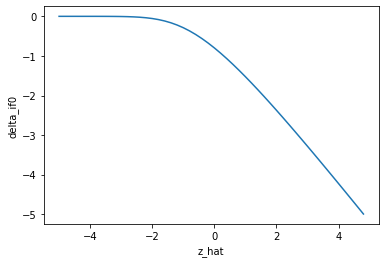

In [7]:
z_hat = np.arange(-5, 5, 0.2)
phi = stats.norm.pdf(-z_hat)
PHI = stats.norm.cdf(-z_hat)
mean_z_if1 = z_hat + phi/(1 - PHI)
mean_z_if0 = z_hat - phi/PHI
delta_if1 = phi/(1 - PHI)
delta_if0 = - phi/PHI
df = pd.DataFrame({'z_hat': z_hat, 'mean_z_if1': mean_z_if1, 'mean_z_if0': mean_z_if0, 'delta_if1': delta_if1, 'delta_if0': delta_if0})
sns.lineplot('z_hat', 'delta_if0', data = df)

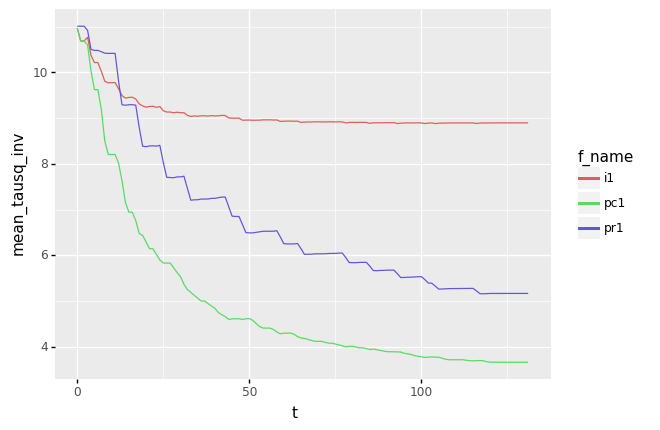

<ggplot: (310702894)>

In [4]:
var = 'mean_tausq_inv'
learn_plot(ds, var, sel = {'f_name': ['pc1', 'pr1', 'i1']})

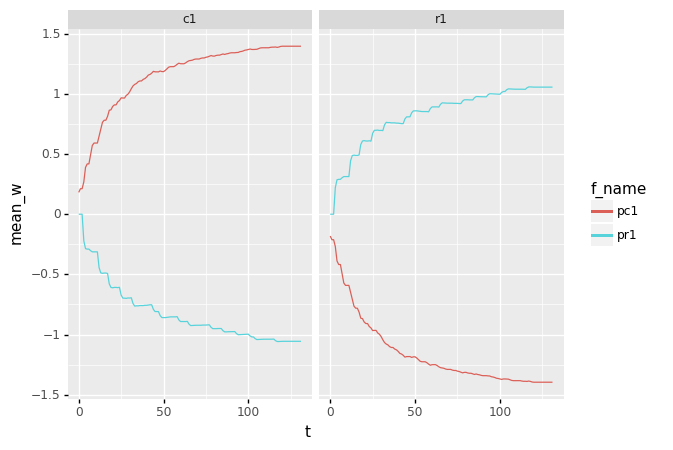

<ggplot: (310628651)>

In [6]:
var = 'mean_w'
learn_plot(ds, var, sel = {'f_name': ['pc1', 'pr1'], 'u_name': ['c1', 'r1']})

In [5]:
pars = [-1, 5, 1]
trials = ibre.make_trials()
ds = m.simulate(trials, par_val = pars)
var = 'mean_tausq_inv'
learn_plot(ds, var, sel = {'f_name': ['pc1', 'pr1', 'i1']})
test_probs = ds['b_hat'].loc[ds.stage_name == 'test'].to_dataframe().reset_index()
mean_test_probs = test_probs.groupby(['trial_name', 'u_name'])['b_hat'].mean()
print(mean_test_probs)

trial_name          u_name
pc1 -> nothing      c1        0.381777
                    c2        0.215522
                    r1        0.187178
                    r2        0.215522
pc1.pr1 -> nothing  c1        0.324107
                    c2        0.210930
                    r1        0.254033
                    r2        0.210930
pc2 -> nothing      c1        0.215475
                    c2        0.381814
                    r1        0.215475
                    r2        0.187236
pc2.pr2 -> nothing  c1        0.210929
                    c2        0.323998
                    r1        0.210929
                    r2        0.254144
pr1 -> nothing      c1        0.202400
                    c2        0.227014
                    r1        0.343571
                    r2        0.227014
pr2 -> nothing      c1        0.227055
                    c2        0.202324
                    r1        0.227055
                    r2        0.343566
Name: b_hat, dtype: float64


In [6]:
# ordinal adequacy test (OAT) for the IBRE

n = 20
max_time = 120
#algorithm = nlopt.GN_DIRECT_L
algorithm = nlopt.GN_AGS
#algorithm = nlopt.GN_ORIG_DIRECT
#algorithm = nlopt.GD_STOGO

#m = ard_linear.model(name = 'elemental ARD', fbase = elem)
m = ard_probit.model(name = 'elemental ARD', fbase = elem)

oat_result = perform_oat(m, ibre, minimize = False, n = n, max_time = max_time, algorithm = algorithm)
print(oat_result.round(5))

     prior_tausq_inv_hpar0  prior_tausq_inv_hpar1    mean    lower    upper
max              -19.99656                9.00244 -0.0755 -0.07845 -0.07256


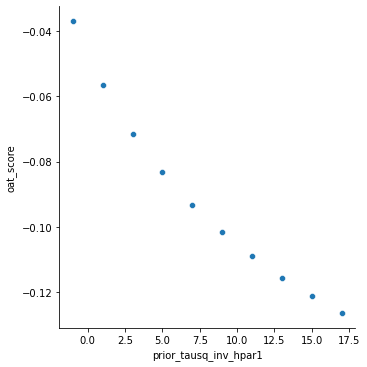

In [7]:
#m = ard_linear.model(name = 'elemental ARD', fbase = elem)
#free_par = 'u_var'
#fixed_values = {'prior_tausq_inv_hpar0': -3, 'prior_tausq_inv_hpar1': 0, 'resp_scale': 5}

m = ard_probit.model(name = 'elemental ARD', fbase = elem)
free_par = 'prior_tausq_inv_hpar1'
fixed_values = {'prior_tausq_inv_hpar0': -10, 'resp_scale': 5}

df = oat_grid(m,
              ibre,
              free_par = free_par,
              fixed_values = fixed_values,
              n_points = 5)
sns.relplot(x = free_par, y = 'oat_score', data = df)

In [5]:
# ordinal adequacy test (OAT) for learned predictiveness
oat_result = perform_oat(m, lrn_pred, n = n, max_time = max_time, algorithm = algorithm)
print(oat_result.round(5))

SystemError: PyEval_EvalFrameEx returned a result with an error set